In [54]:
# All imported libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras import Model
from keras import optimizers
from keras.models import Sequential
# from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import time
import math

## Loading data
This function loads all data into their own numpy arrays.

In [55]:
# Function that loads all required data in its own np array.
def load_and_preprocess_dataset():
    x_train = []
    y_train = []
    data = os.listdir('CarsSet/DATA/DATA/train')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/train', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_train.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/train', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_train.append(bbox)
    
    
    x_val = []
    y_val = []
    data = os.listdir('CarsSet/DATA/DATA/validate')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/validate', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_val.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/validate', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_val.append(bbox)


    x_test = []
    y_test = []
    data = os.listdir('CarsSet/DATA/DATA/test')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/test', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_test.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/test', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_test.append(bbox)
            
    x_multi = []
    data = os.listdir('CarsSet/DATA/DATA/multiple_experiment')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/multiple_experiment', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_multi.append(img)

    x_above = []
    data = os.listdir('CarsSet/DATA/DATA/above_experiment')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/above_experiment', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_above.append(img)

    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test), np.array(x_multi), np.array(x_above)


In [56]:
# Load and preprocess the dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test, X_multi, X_above = load_and_preprocess_dataset()

## Neural network using Sequential model
This model has several convolutional layers followed by max pooling layers to extract features from the input images. The feature maps are then flattened and fed into a dense layer. The output layer has 4 units corresponding to the coordinates of the bounding box (x1, y1, x2, y2) for car detection.

In [57]:
# Define the sequential model
mod_seq_bgr = Sequential()

# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Set the input shape
mod_seq_bgr.add(Input(shape=input_shape))

# Add convolutional layers
mod_seq_bgr.add(Conv2D(32, (3, 3), activation='relu'))
mod_seq_bgr.add(MaxPooling2D((2, 2)))
mod_seq_bgr.add(Conv2D(64, (3, 3), activation='relu'))
mod_seq_bgr.add(MaxPooling2D((2, 2)))
mod_seq_bgr.add(Conv2D(128, (3, 3), activation='relu'))
mod_seq_bgr.add(MaxPooling2D((2, 2)))
mod_seq_bgr.add(Conv2D(256, (3, 3), activation='relu'))
mod_seq_bgr.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
mod_seq_bgr.add(Flatten())

# Add a dense layer
mod_seq_bgr.add(Dense(256, activation='relu'))

# Output layer for bounding box regression
mod_seq_bgr.add(Dense(4, activation='linear'))

# Compile the model
mod_seq_bgr.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
mod_seq_bgr.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,826,884 (37.49 MB)

 Trainable params: 9,826,884 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

## Neural network using pretrained VGG16
In the following code I make a model based on the VGG16 model from Keras. For detecting cars in images, the VGG16 model can be fine-tuned on a dataset of car images, where the last fully connected layer is replaced with a new output layer that predicts the bounding box coordinates of the car in the image. The pre-trained weights of the model can then be fine-tuned on this new task, which allows the model to learn to detect cars in images with high accuracy.

To fine-tune the VGG16 model I dont include the top classification layer and make it myself. 
These lines add a flatten layer and a dense layer on top of the pre-trained VGG16 model. The Flatten layer flattens the output from the previous layer to a 1D tensor. The first Dense layer has 256 units with a ReLU activation function. The final Dense layer has 4 units with a linear activation function.

In [58]:
# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a flatten layer and a dense layer for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='linear')(x)

# Create a new model with input and output layers, so that only the weights of the new top classification layer will be updated during training.
mod_vgg_bgr = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
mod_vgg_bgr.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

mod_vgg_bgr.summary()


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Using only HUE instead of BGR.
In this experiment I will add a HSV filter. So the training gets done on only the HUE to check if this can decrease the loss.

In [59]:
def extract_hue_channel_only(X_train, X_val, X_test, X_multi, X_above):
    def get_hue(images):
        hue_only = []
        for img in images:
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convert from BGR to HSV
            hue_channel = hsv_img[:, :, 0]  # Extract only the HUE channel
            hue_only.append(hue_channel)
        return np.array(hue_only)

    X_HUEONLY_train = get_hue(X_train)
    X_HUEONLY_val = get_hue(X_val)
    X_HUEONLY_test = get_hue(X_test)
    X_HUEONLY_multi = get_hue(X_multi)
    X_HUEONLY_above = get_hue(X_above)

    return X_HUEONLY_train, X_HUEONLY_val, X_HUEONLY_test, X_HUEONLY_multi, X_HUEONLY_above

In [60]:
# Extract the HUE channel only from the images
X_HUEONLY_train, X_HUEONLY_val, X_HUEONLY_test, X_HUEONLY_multi, X_HUEONLY_above = extract_hue_channel_only(
    X_train, X_val, X_test, X_multi, X_above)

# Add channel dimension to all HUE arrays
X_HUEONLY_train = np.expand_dims(X_HUEONLY_train, axis=-1)
X_HUEONLY_val = np.expand_dims(X_HUEONLY_val, axis=-1)
X_HUEONLY_test = np.expand_dims(X_HUEONLY_test, axis=-1)
X_HUEONLY_multi = np.expand_dims(X_HUEONLY_multi, axis=-1)
X_HUEONLY_above = np.expand_dims(X_HUEONLY_above, axis=-1)

# Normalize the HUE values to be between 0 and 1
X_HUEONLY_train = X_HUEONLY_train / 179.0
X_HUEONLY_val = X_HUEONLY_val / 179.0
X_HUEONLY_test = X_HUEONLY_test / 179.0
X_HUEONLY_multi = X_HUEONLY_multi / 179.0
X_HUEONLY_above = X_HUEONLY_above / 179.0

In [61]:
# Define the sequential model with HUE channel only
mod_seq_hue = Sequential()

# Get the input shape from X_HUEONLY_train
input_shape = X_HUEONLY_train.shape[1:]

# Set the input shape
mod_seq_hue.add(Input(shape=input_shape))

# Add convolutional layers
mod_seq_hue.add(Conv2D(32, (3, 3), activation='relu'))
mod_seq_hue.add(MaxPooling2D((2, 2)))
mod_seq_hue.add(Conv2D(64, (3, 3), activation='relu'))
mod_seq_hue.add(MaxPooling2D((2, 2)))
mod_seq_hue.add(Conv2D(128, (3, 3), activation='relu'))
mod_seq_hue.add(MaxPooling2D((2, 2)))
mod_seq_hue.add(Conv2D(256, (3, 3), activation='relu'))
mod_seq_hue.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
mod_seq_hue.add(Flatten())

# Add a dense layer
mod_seq_hue.add(Dense(256, activation='relu'))

# Output layer for bounding box regression
mod_seq_hue.add(Dense(4, activation='linear'))

# Compile the model
mod_seq_hue.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
mod_seq_hue.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,826,308 (37.48 MB)

 Trainable params: 9,826,308 (37.48 MB)

 Non-trainable params: 0 (0.00 B)

# Add more training by moving images over
Meer training krijgen door plaatje een stuk op te schuiven. Naam hiervoor opzoeken. Ook controleren hoe de convolution werkt.

# Add dropout layers
Dropout layer toevoegen voor de flatten en misschien voor de conv layers. De loss moet ongeveer gelijk zijn. Tussen test en val data.

## Training the Models
The models are being trained below, I am using 10 epochs because it does not find much improvement after that.

In [62]:
# Train the model
hist_seq_bgr = mod_seq_bgr.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val), batch_size=32)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - loss: 195182.7656 - val_loss: 9910.8994
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - loss: 5237.0215 - val_loss: 2010.7938
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 542ms/step - loss: 1762.2811 - val_loss: 812.4481
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - loss: 1039.0847 - val_loss: 705.2831
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - loss: 893.2306 - val_loss: 708.5028
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - loss: 817.5739 - val_loss: 681.9649
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - loss: 765.4304 - val_loss: 740.3456
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - loss: 724.1880 - val_loss: 743.7679
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - loss: 657.6440 - val_loss: 934.1247
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - loss: 801.0776 - val_loss: 756.8876
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - loss: 608.8600 - val_loss: 612.8658
Epoch 12/40
9/9 ━━━━━━

In [63]:
# Train the model
hist_seq_hue = mod_seq_hue.fit(X_HUEONLY_train, Y_train, epochs=40, validation_data=(X_HUEONLY_val, Y_val), batch_size=32)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 512ms/step - loss: 14394.1377 - val_loss: 5806.2490
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - loss: 5435.9619 - val_loss: 1839.3262
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - loss: 2384.2947 - val_loss: 2010.7916
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - loss: 1908.7834 - val_loss: 1112.9652
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - loss: 1363.8312 - val_loss: 845.8688
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - loss: 996.2827 - val_loss: 656.1769
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - loss: 752.5098 - val_loss: 593.9286
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - loss: 726.5723 - val_loss: 386.3044
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - loss: 699.8535 - val_loss: 624.5651
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - loss: 716.6126 - val_loss: 575.9083
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - loss: 683.9392 - val_loss: 405.9009
Epoch 12/40
9/9 ━━━━

# Results of using the HUE-Only filter
To evaluate the impact of isolating the HUE channel from RGB images, two models were trained: one using the full BGR input and another using only the HUE channel extracted via HSV conversion.

Training Results:

| Model Type | Training Loss | Validation Loss |
|---------|----------|---------|
BGR Input |	+/- 6    | +/- 650 |
HUE Only  |	+/- 380  | +/- 360 |

## Interpretation:
#### Training Loss:
The BGR model clearly learns more effectively during training, reaching a significantly lower loss.
The HUE-only model struggles to converge, indicated by a much higher training loss (380 vs. 6). This suggests that the model has a harder time fitting the data when it's only given the hue channel.

#### Validation Loss:
Interestingly, the HUE-only model performs better on the validation set, achieving a lower loss (360 vs. 650).
This suggests that the hue information may help the model generalize slightly better on unseen data, possibly due to reduced overfitting. Hue captures broad color distinctions while discarding brightness and saturation, which might add noise in some contexts.

## What These Results Mean:
The BGR model learns faster and fits better, but it may be overfitting—especially since it performs worse on validation data.
The HUE-only model is less capable during training (due to limited information), but possibly generalizes better due to the simplification of the input data.

## Possible Improvements:
#### 1 Combine HUE with other channels:
Instead of using only HUE, combining it with Saturation or Value, or use all 3 HSV channels, could provide more complete color information while still transforming away from raw BGR.

#### 2 Reduce overfitting in BGR model:
Use dropout or batch normalization in the BGR model to reduce overfitting.

# Training the VGG16 model
This model should be very good in detecting cars in images.

In [64]:
# Train the model
hist_vgg_bgr = mod_vgg_bgr.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=32)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 13452.8848 - mean_squared_error: 13452.8848 - val_loss: 5809.6665 - val_mean_squared_error: 5809.6665
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 4849.6416 - mean_squared_error: 4849.6416 - val_loss: 2050.4971 - val_mean_squared_error: 2050.4971
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2169.3359 - mean_squared_error: 2169.3359 - val_loss: 2221.7859 - val_mean_squared_error: 2221.7859
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 964.7662 - mean_squared_error: 964.7662 - val_loss: 688.0602 - val_mean_squared_error: 688.0602
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 404.1143 - mean_squared_error: 404.1143 - val_loss: 1023.6628 - val_mean_squared_error: 1023.6628
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 247.3176 - mean_squared_error: 247.3176 - val_loss: 575.9530 - val_mean_squared_error: 575.9530
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 133.7917 - mean_

## Results training
Below are the results of training the model. As can be seen in the histogram, the algorithm quickly improves in recognizing cars. This is also evident in the orange line, which validates this.

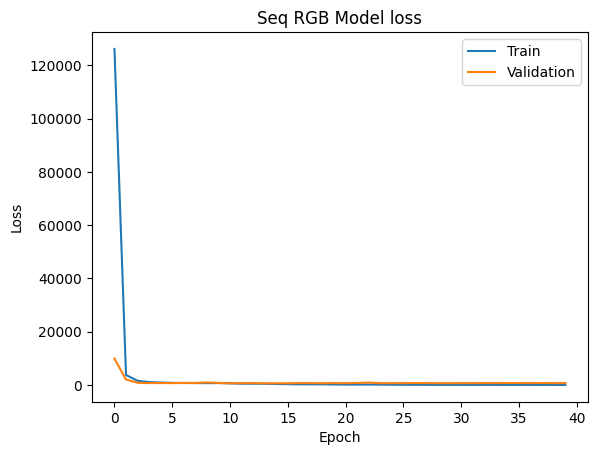

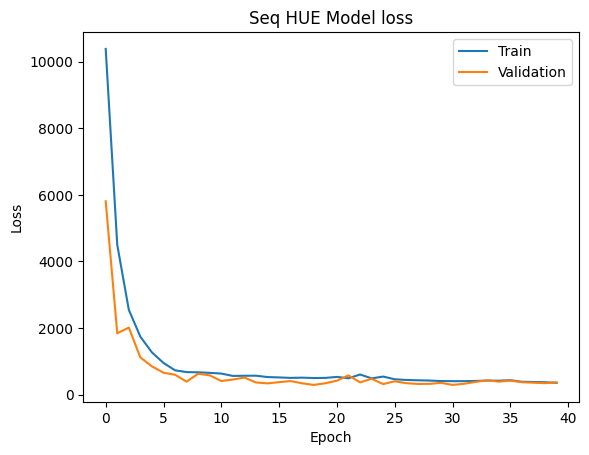

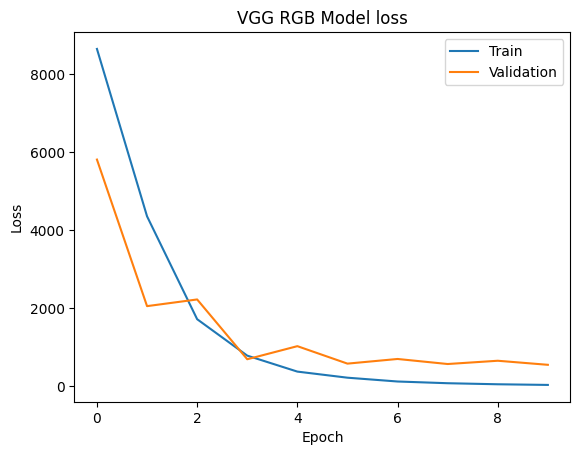

In [65]:
# Plot training & validation loss values
plt.plot(hist_seq_bgr.history['loss'])
plt.plot(hist_seq_bgr.history['val_loss'])
plt.title('Seq RGB Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(hist_seq_hue.history['loss'])
plt.plot(hist_seq_hue.history['val_loss'])
plt.title('Seq HUE Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(hist_vgg_bgr.history['loss'])
plt.plot(hist_vgg_bgr.history['val_loss'])
plt.title('VGG RGB Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Results
As can be seen in the images, both models can usually extract the car from the image. The bounding box is not always perfectly around the car, but it usually identifies the headlights. It sometimes struggles with clouds and mountains, where the models can be almost completely wrong. 

On average the Sequential is about 28.5 off and the VGG16 is about 21 so the VGG16 works better.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
0.434934139251709  seconds to predict bounding boxes.


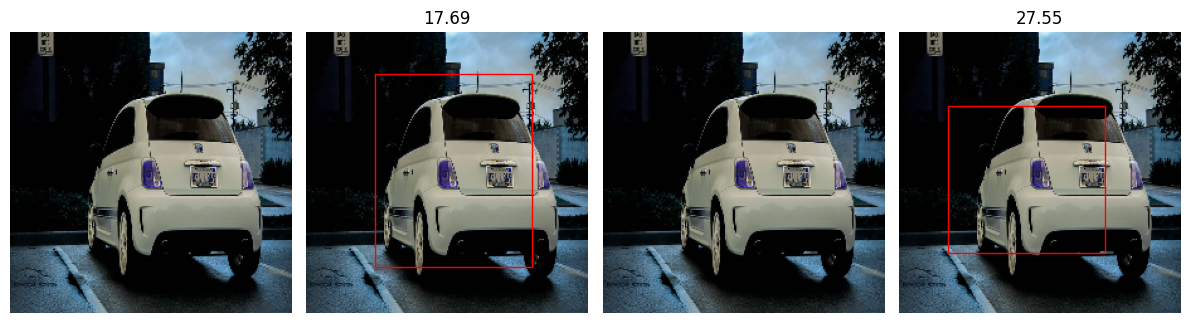

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.2465815544128418  seconds to predict bounding boxes.


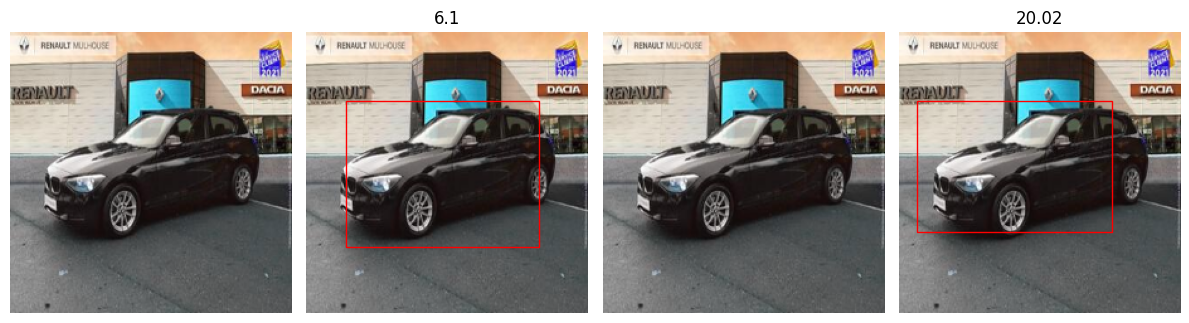

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
0.27625226974487305  seconds to predict bounding boxes.


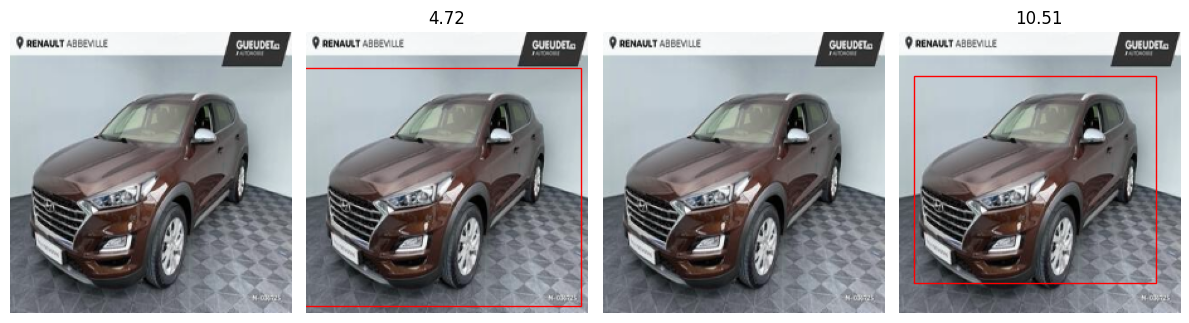

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
0.2907087802886963  seconds to predict bounding boxes.


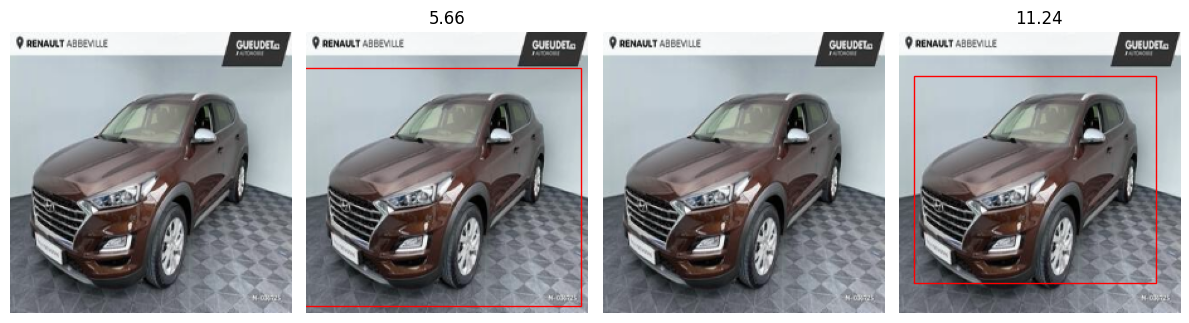

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
0.2753453254699707  seconds to predict bounding boxes.


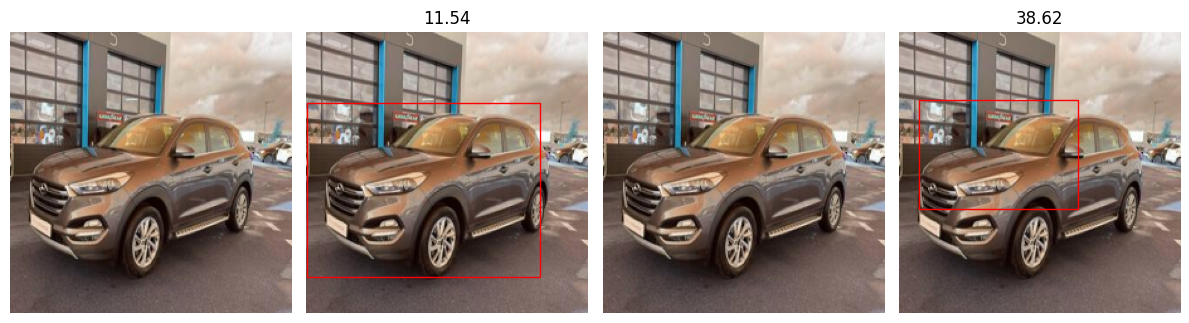

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.2611701488494873  seconds to predict bounding boxes.


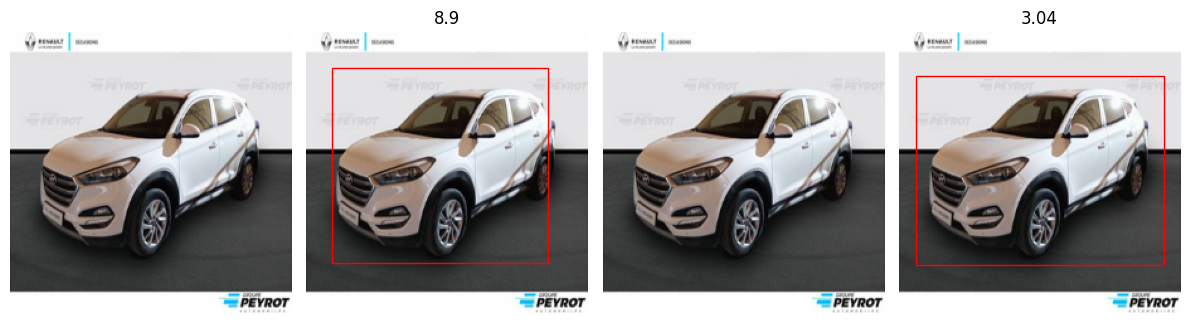

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
0.25719213485717773  seconds to predict bounding boxes.


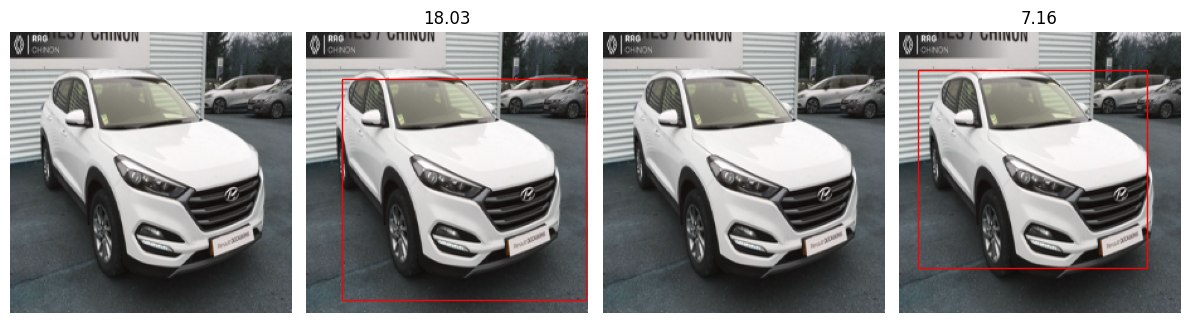

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
0.27622532844543457  seconds to predict bounding boxes.


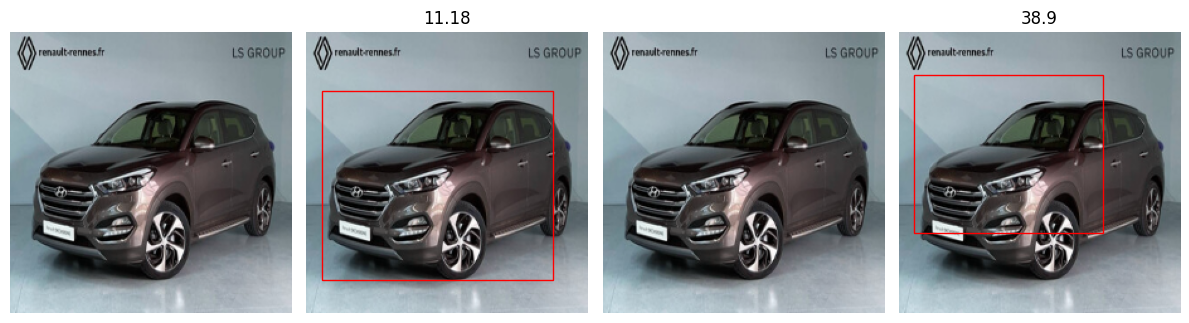

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
0.26169919967651367  seconds to predict bounding boxes.


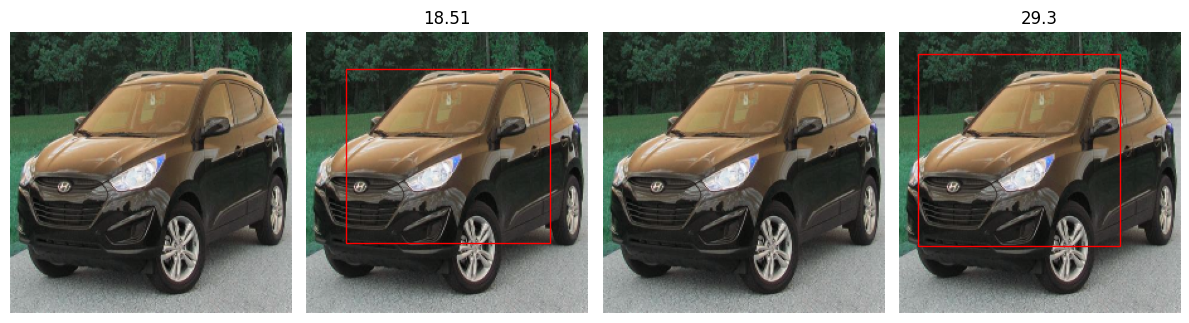

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
0.26211023330688477  seconds to predict bounding boxes.


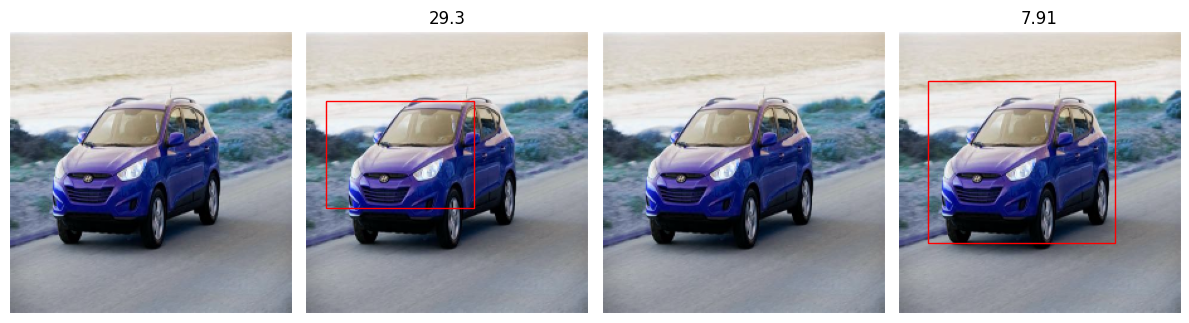

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
0.28872251510620117  seconds to predict bounding boxes.


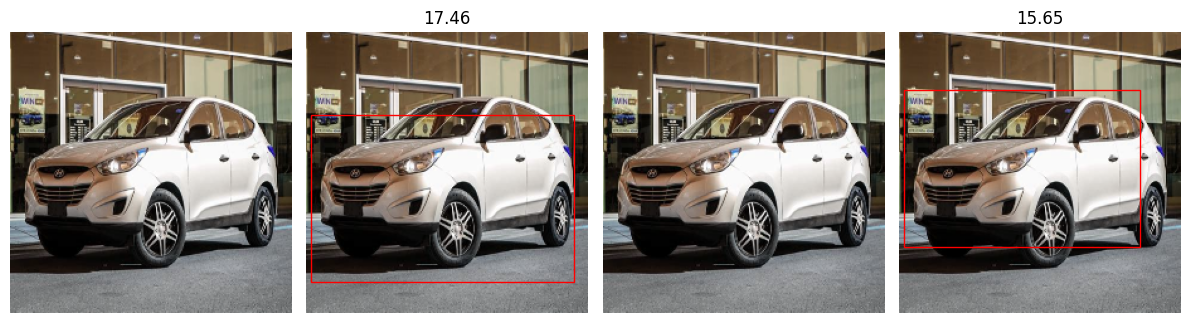

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
0.25861334800720215  seconds to predict bounding boxes.


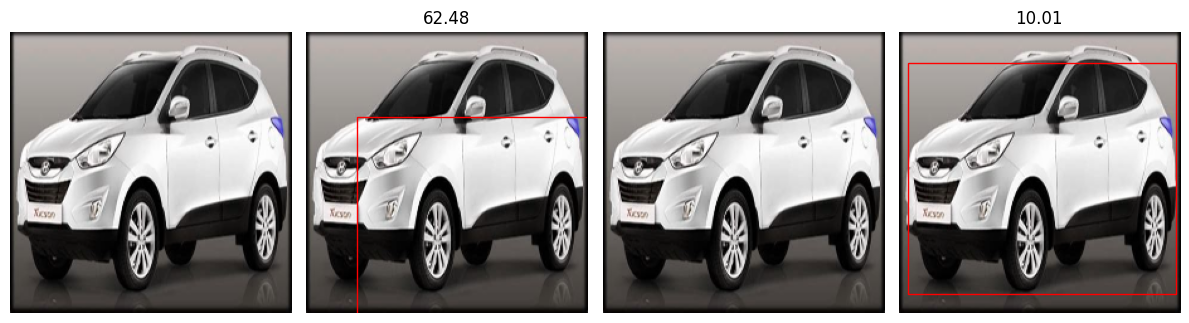

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
0.2566814422607422  seconds to predict bounding boxes.


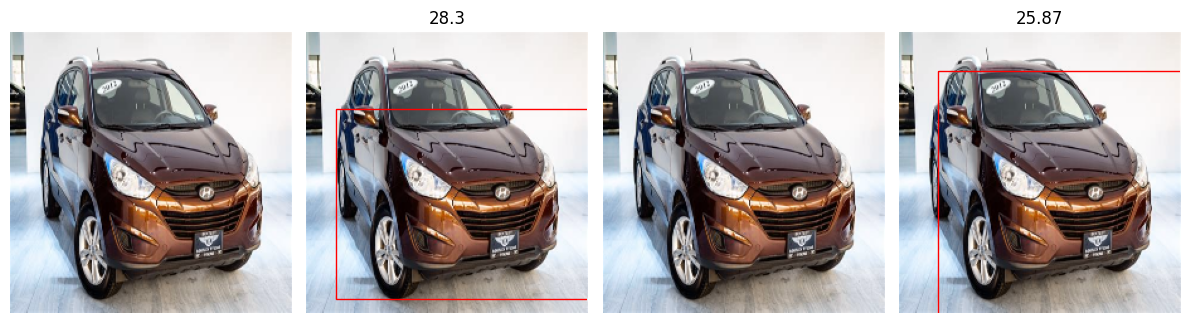

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
0.30037641525268555  seconds to predict bounding boxes.


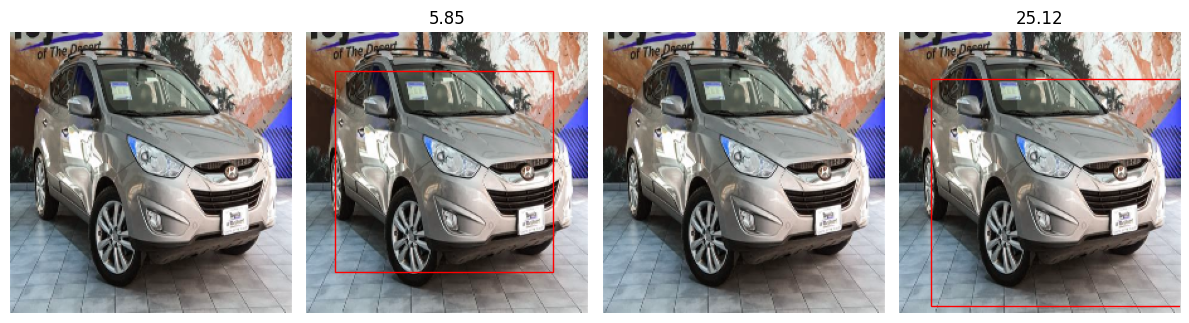

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.24811244010925293  seconds to predict bounding boxes.


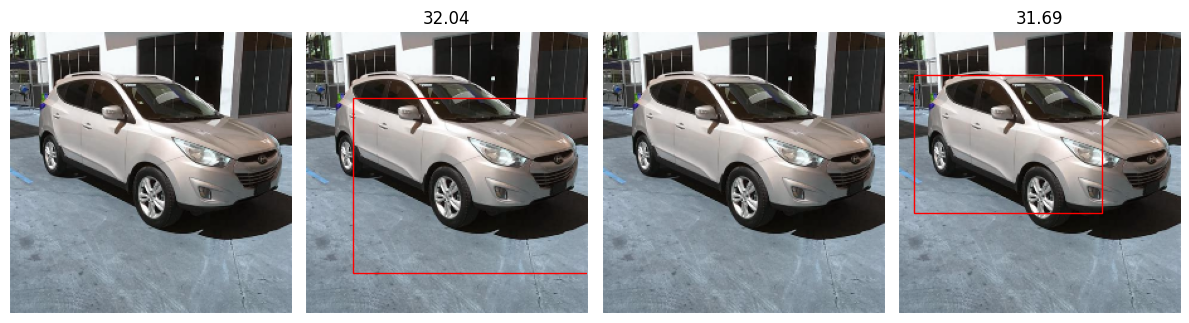

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.24405837059020996  seconds to predict bounding boxes.


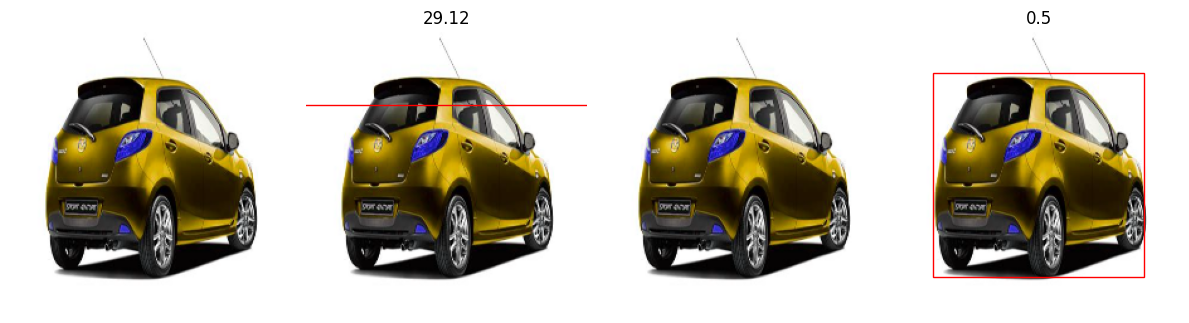

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
0.26670169830322266  seconds to predict bounding boxes.


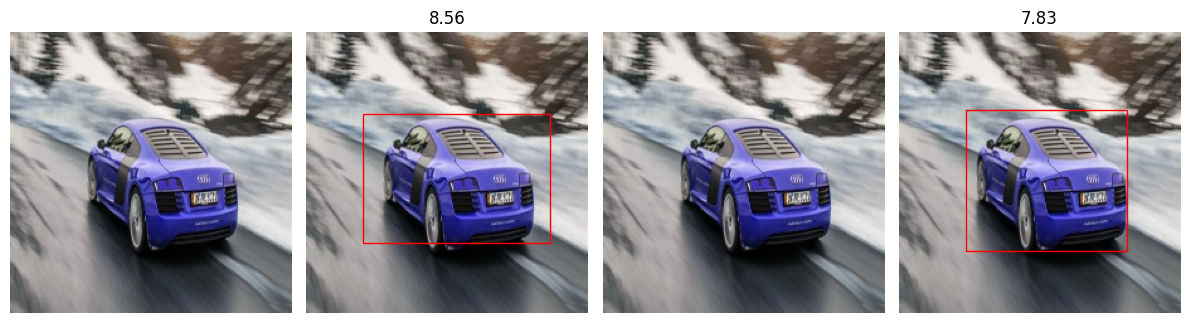

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
0.2696719169616699  seconds to predict bounding boxes.


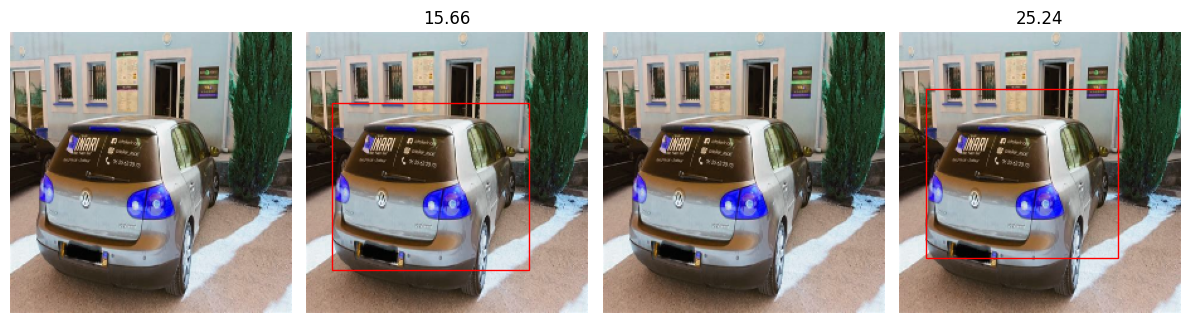

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
0.3002598285675049  seconds to predict bounding boxes.


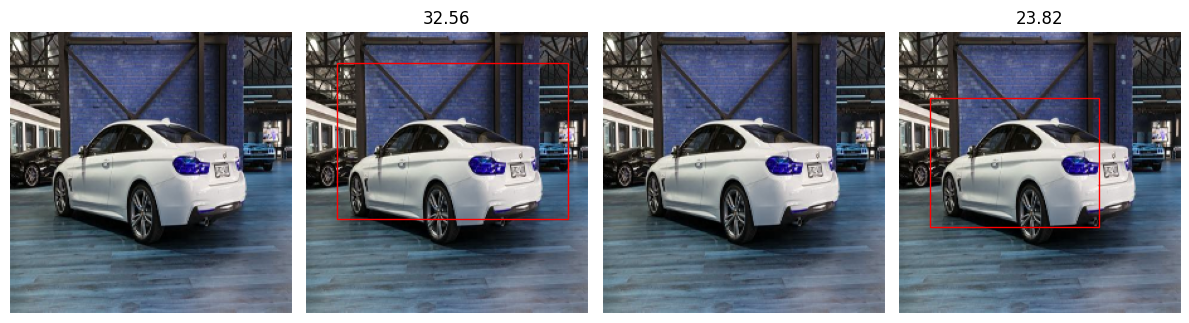

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.24506258964538574  seconds to predict bounding boxes.


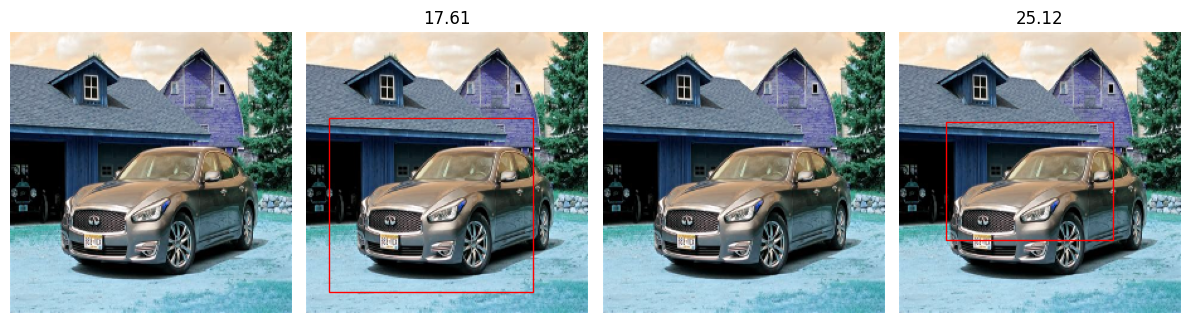

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
0.2525906562805176  seconds to predict bounding boxes.


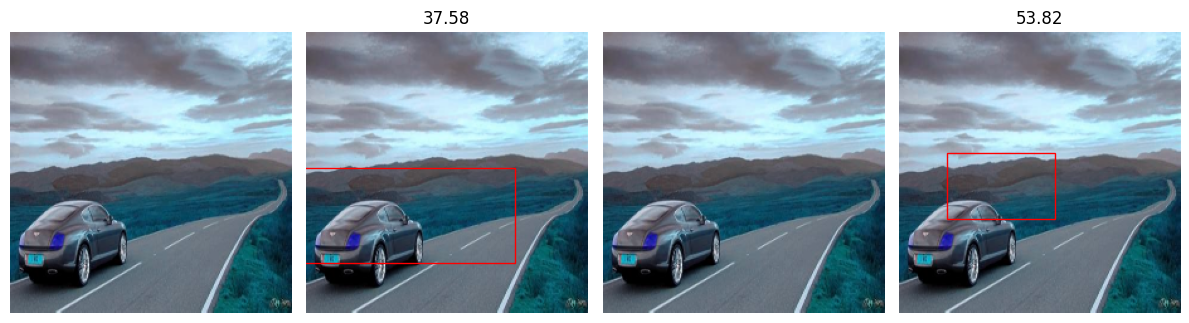

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
0.26618361473083496  seconds to predict bounding boxes.


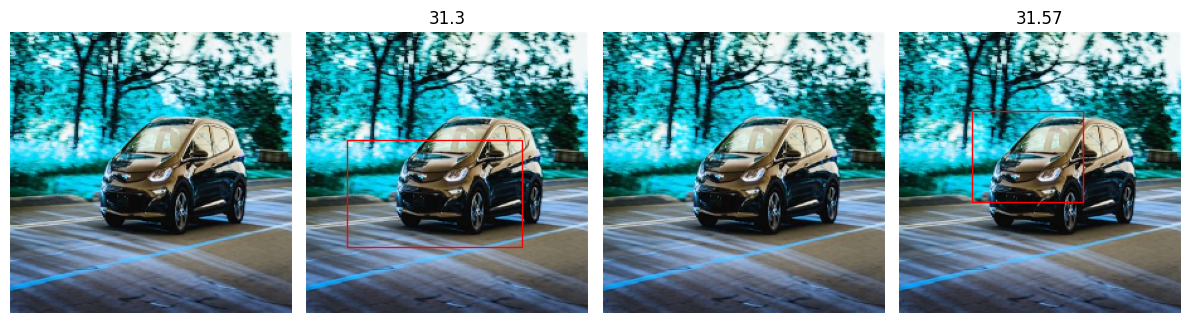

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
0.2500772476196289  seconds to predict bounding boxes.


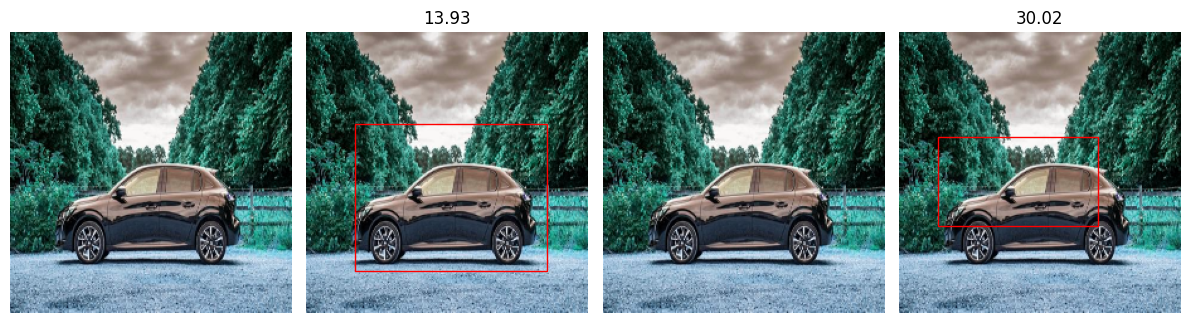

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
0.2581644058227539  seconds to predict bounding boxes.


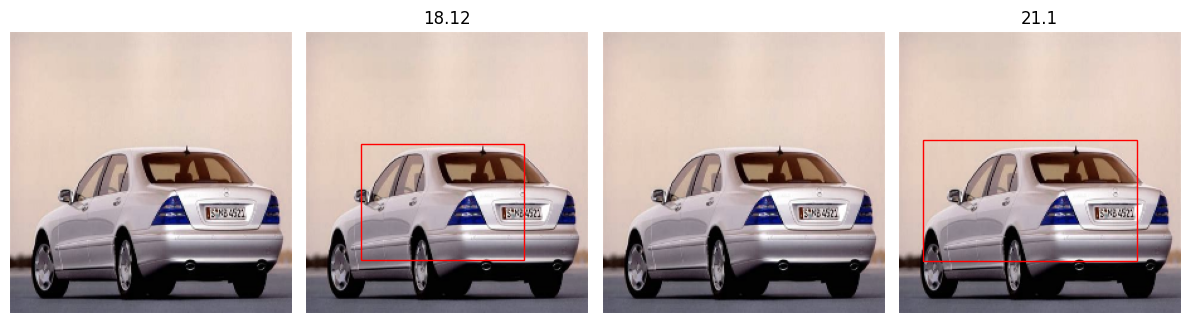

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
0.2595970630645752  seconds to predict bounding boxes.


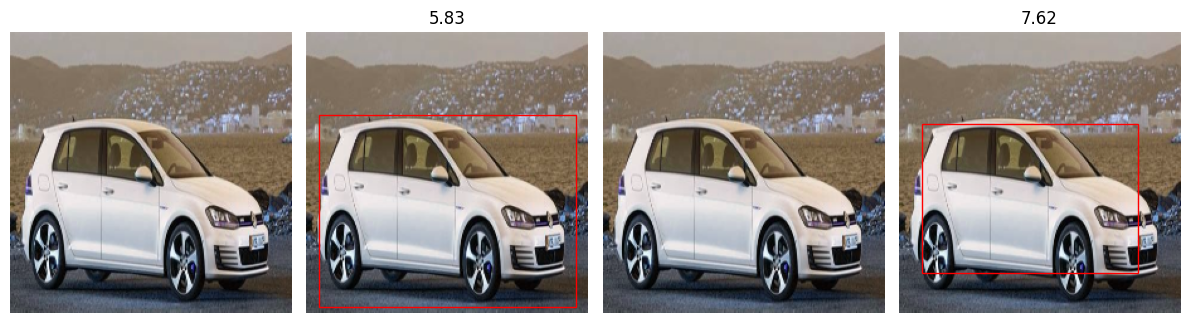

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
0.26215291023254395  seconds to predict bounding boxes.


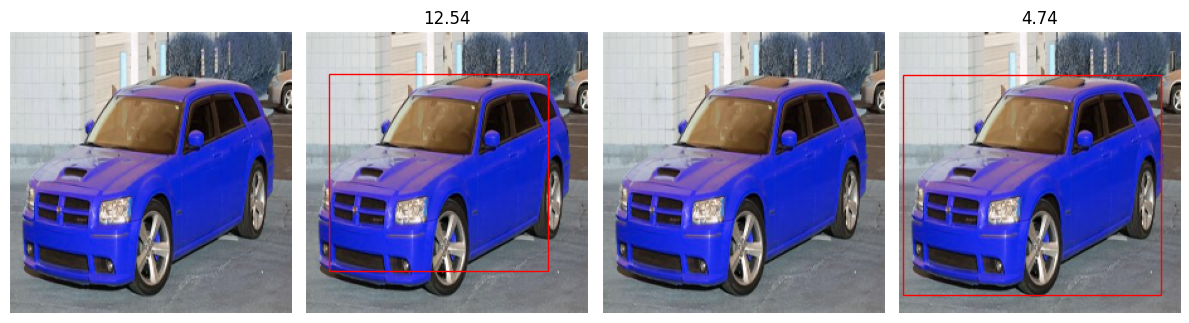

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
0.30985379219055176  seconds to predict bounding boxes.


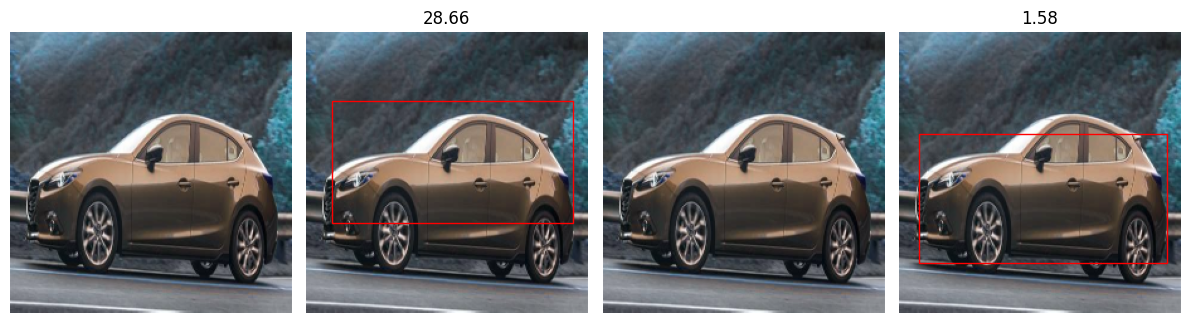

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.2506721019744873  seconds to predict bounding boxes.


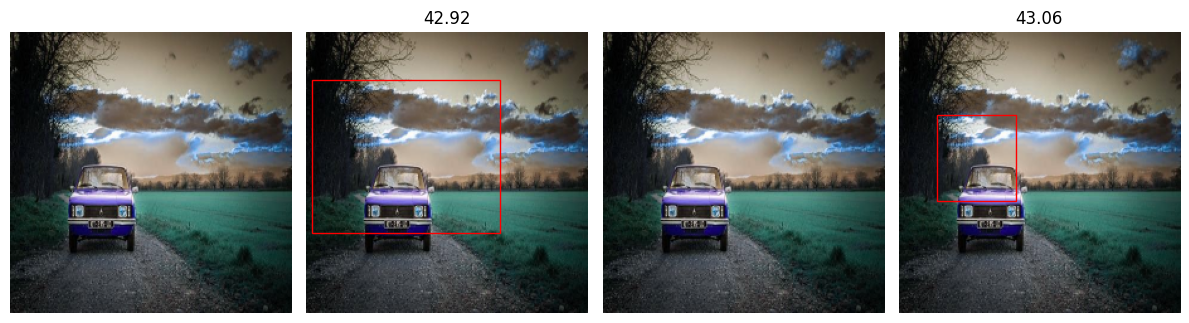

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
0.28023767471313477  seconds to predict bounding boxes.


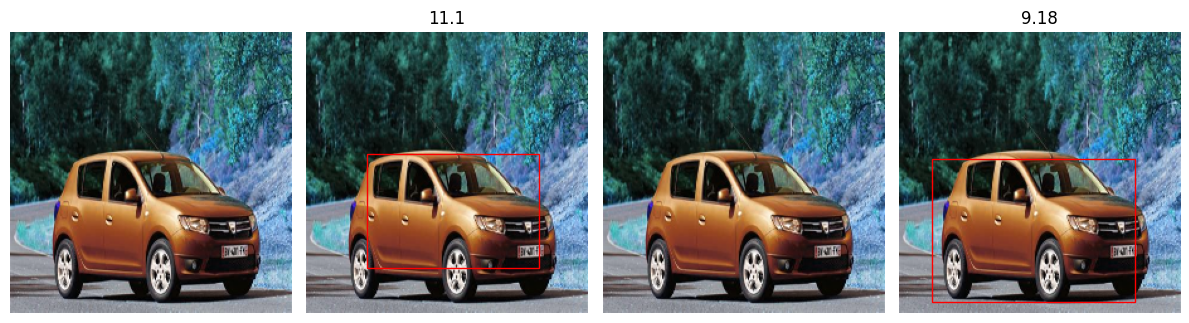

Average distance of Sequential:  20.112068965517242
Average distance of VGG:  20.26862068965517


In [66]:
# Calculates the distance between two rectangles defined by their 4 corner points.
def rectangle_distance(rect1, rect2):
    # Calculate the midpoint of each rectangle
    rect1_midpoint = ((rect1[0] + rect1[2]) / 2, (rect1[1] + rect1[3]) / 2)
    rect2_midpoint = ((rect2[0] + rect2[2]) / 2, (rect2[1] + rect2[3]) / 2)

    # Calculate the distance between the midpoints
    distance = math.sqrt((rect1_midpoint[0] - rect2_midpoint[0])**2 + (rect1_midpoint[1] - rect2_midpoint[1])**2)

    return round(distance, 2)

# Display one image without and one image with bounding boxes.
def display_images(path1, x1, y1, x2, y2, distance1, path2, x3, y3, x4, y4, distance2):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    
    # Image 1 without bounding box
    ax[0].imshow(path1)
    ax[0].axis("off")
    
    # Image 1 with bounding box
    ax[1].imshow(path1)
    ax[1].set_title(distance1)
    rect1 = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect1)
    ax[1].axis("off")
    
    # Image 2 without bounding box
    ax[2].imshow(path2)
    ax[2].axis("off")
    
    # Image 2 with bounding box
    ax[3].imshow(path2)
    ax[3].set_title(distance2)
    rect2 = patches.Rectangle((x3, y3), x4-x3, y4-y3, linewidth=1, edgecolor='r', facecolor='none')
    ax[3].add_patch(rect2)
    ax[3].axis("off")
    
    plt.tight_layout()
    plt.show()


totalDistance1 = 0
totalDistance2 = 0

# Loop through the image filenames and process each image
for index in range(len(X_test)):
    start = time.time()
    image = np.expand_dims(X_test[index], axis=0)
    preds1 = mod_seq_bgr.predict(image)
    preds2 = mod_vgg_bgr.predict(image)
    print(time.time() - start, " seconds to predict bounding boxes.")
    x1, y1, x2, y2 = preds1.astype('int')[0]
    x3, y3, x4, y4 = preds2.astype('int')[0]
    distance1 = rectangle_distance(Y_test[index], (x1, y1, x2, y2))
    totalDistance1 += distance1
    distance2 = rectangle_distance(Y_test[index], (x3, y3, x4, y4))
    totalDistance2 += distance2
    display_images(X_test[index], x1, y1, x2, y2, distance1, X_test[index], x3, y3, x4, y4, distance2)

print("Average distance of Sequential: ", totalDistance1 / len(X_test))
print("Average distance of VGG: ", totalDistance2 / len(X_test))


# Experimenten
Om te testen of het model ook werkt op foto's die niet in de dataset staan heb ik een aantal experimenten bedacht.



### Experiment 1: Meerdere auto's in een foto.
In dit experiment ga ik kijken wat er gebeurd als er meerdere auto's in een afbeelding staat.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
0.2677004337310791  seconds to predict bounding boxes.


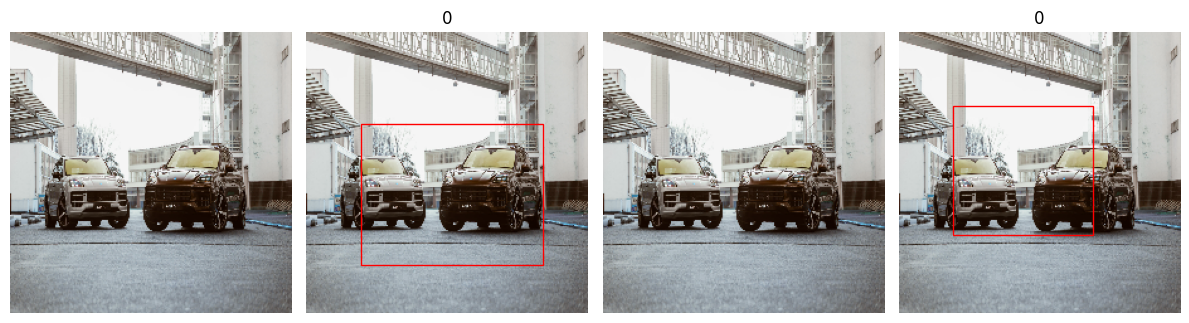

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
0.27582716941833496  seconds to predict bounding boxes.


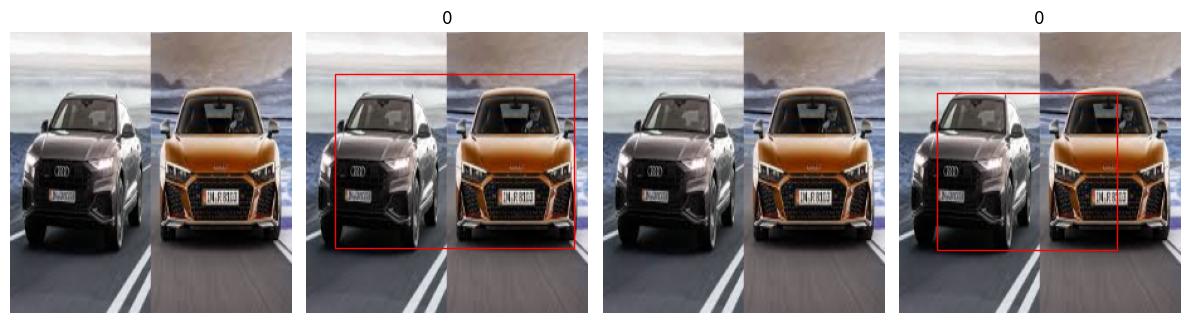

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
0.25310754776000977  seconds to predict bounding boxes.


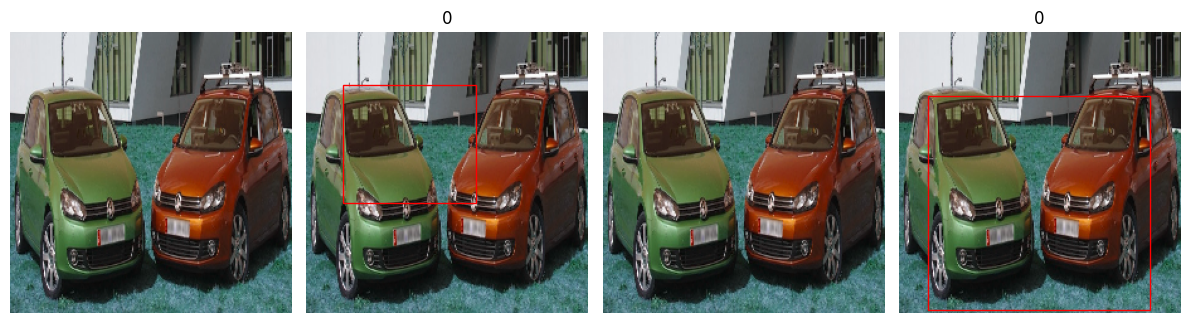

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
0.26123523712158203  seconds to predict bounding boxes.


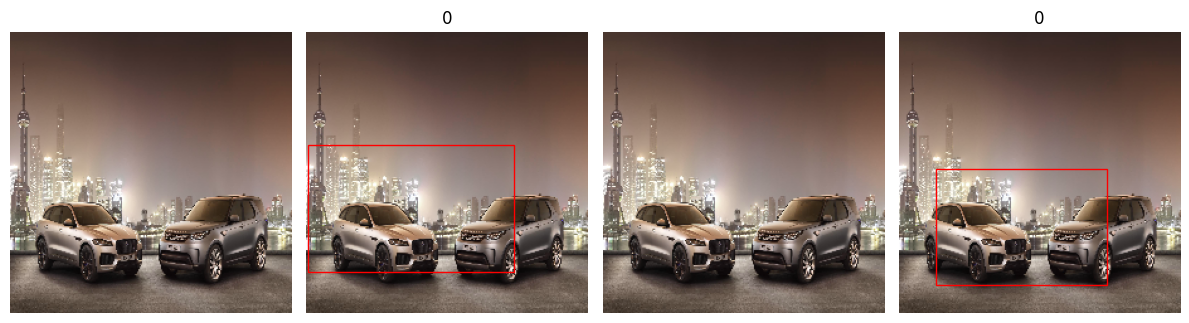

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
0.2857682704925537  seconds to predict bounding boxes.


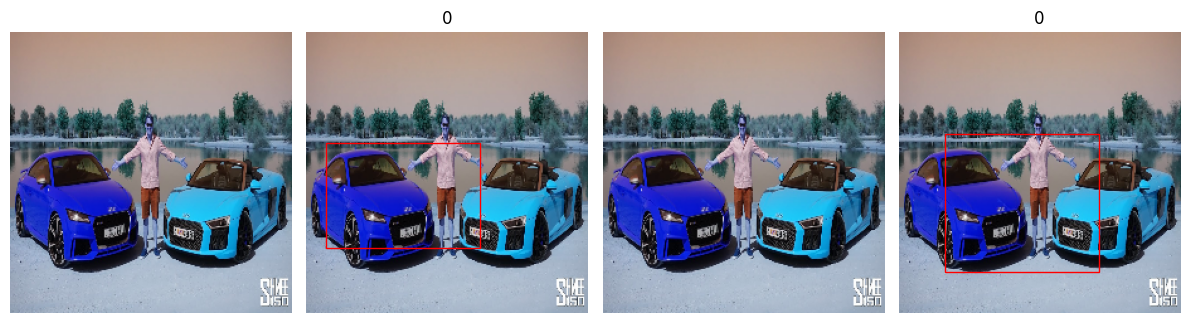

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
0.25006890296936035  seconds to predict bounding boxes.


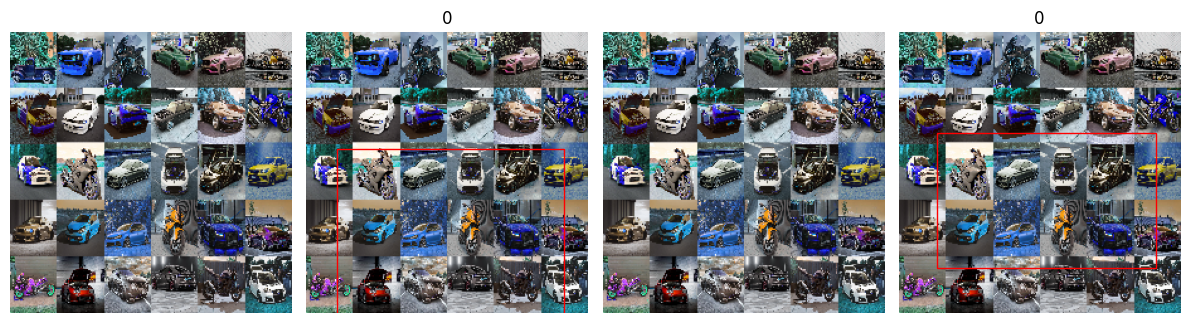

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
0.25563526153564453  seconds to predict bounding boxes.


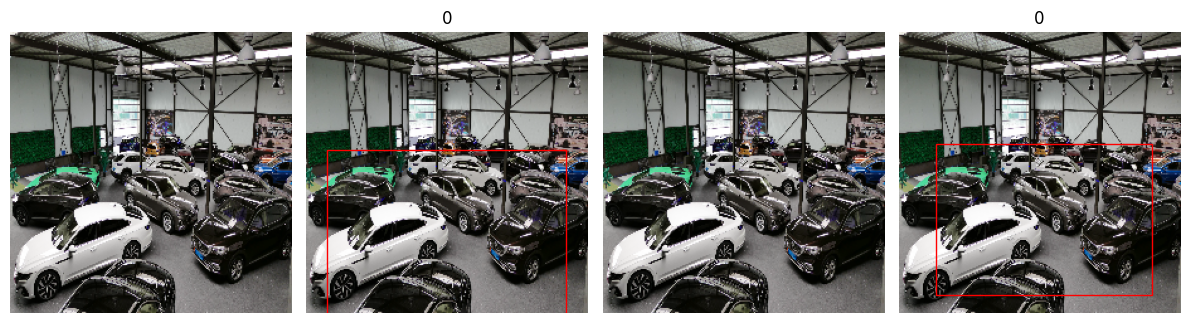

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
0.25766682624816895  seconds to predict bounding boxes.


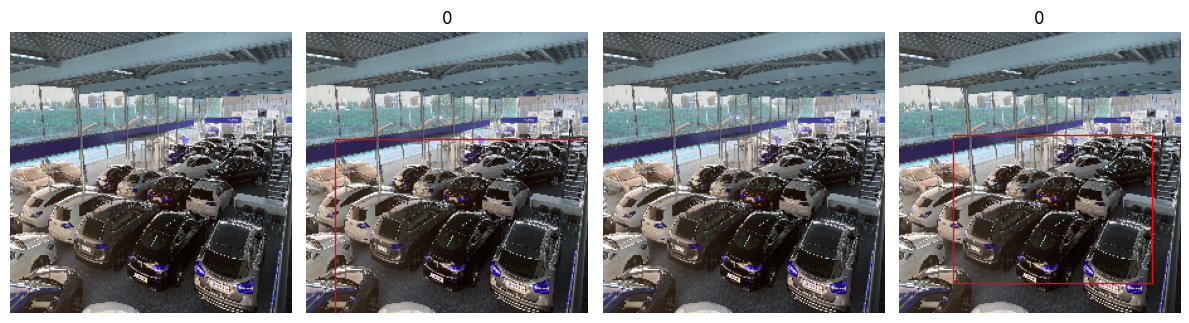

In [67]:
# Loop through the image filenames and process each image
for index in range(len(X_multi)):
    start = time.time()
    image = np.expand_dims(X_multi[index], axis=0)
    preds1 = mod_seq_bgr.predict(image)
    preds2 = mod_vgg_bgr.predict(image)
    print(time.time() - start, " seconds to predict bounding boxes.")
    x1, y1, x2, y2 = preds1.astype('int')[0]
    x3, y3, x4, y4 = preds2.astype('int')[0]
    display_images(X_multi[index], x1, y1, x2, y2, 0, X_multi[index], x3, y3, x4, y4, 0)
    

### Experiment 2: Auto's van bovenaf.
In dit experiment ga ik kijken hoe goed de auto's herkend kunnen worden door het model als de auto's van bovenaf op de afbeelding staan.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
0.25014209747314453  seconds to predict bounding boxes.


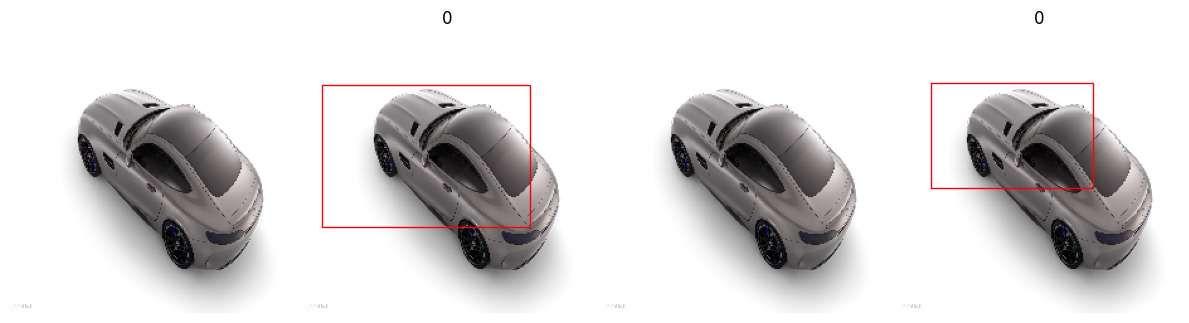

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
0.25559306144714355  seconds to predict bounding boxes.


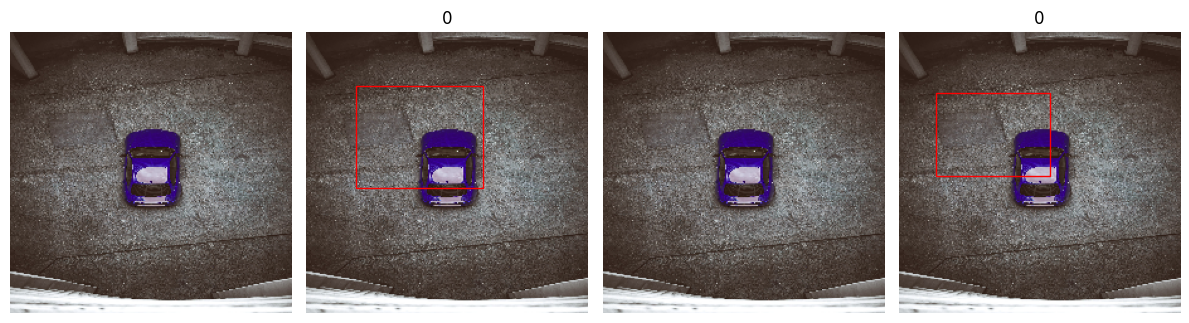

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
0.2741677761077881  seconds to predict bounding boxes.


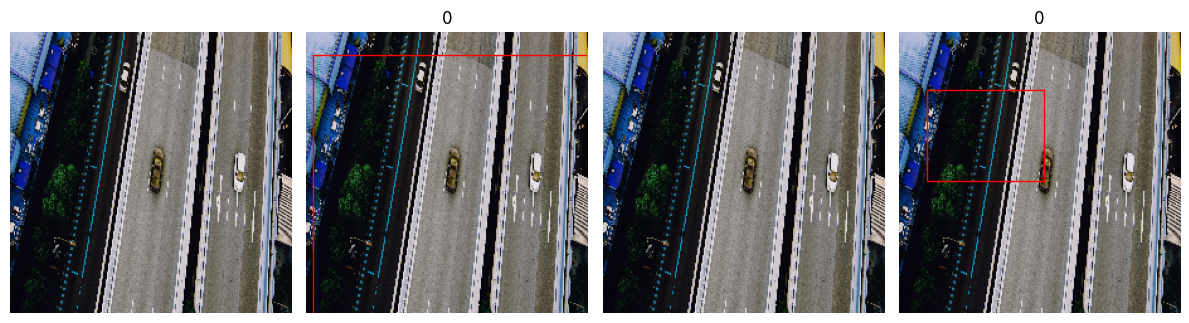

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
0.25814056396484375  seconds to predict bounding boxes.


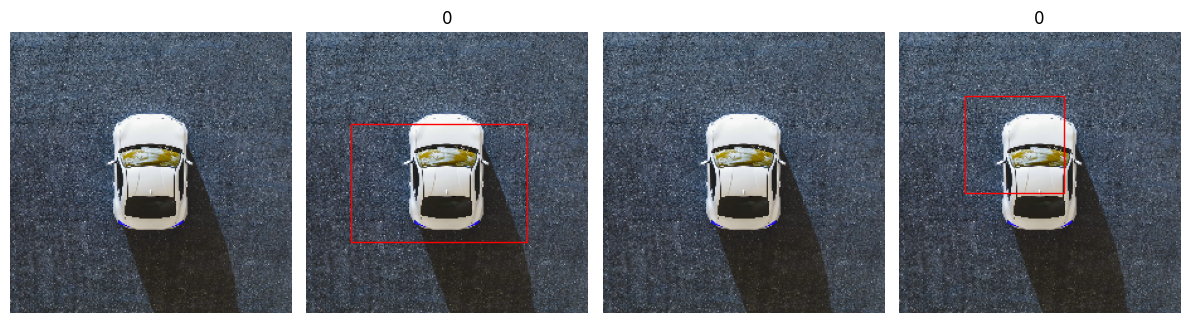

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
0.2746467590332031  seconds to predict bounding boxes.


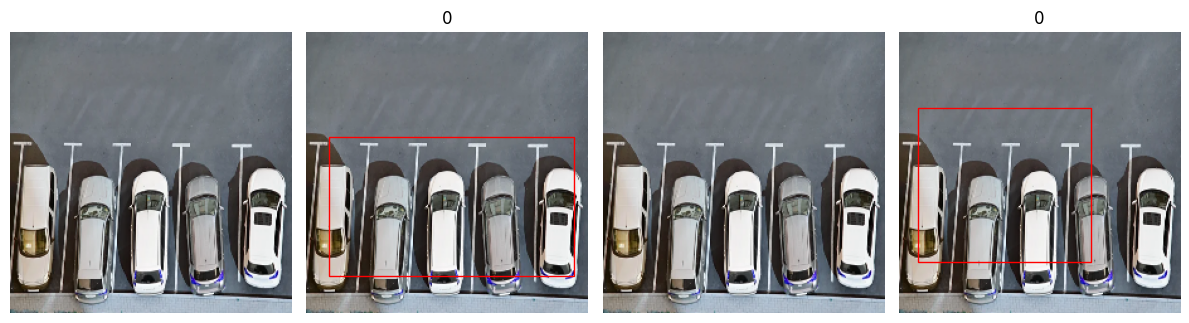

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
0.2561178207397461  seconds to predict bounding boxes.


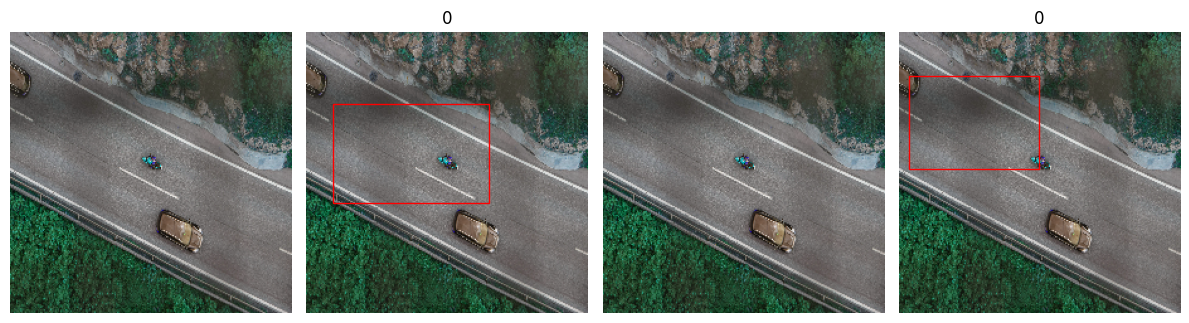

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
0.24309706687927246  seconds to predict bounding boxes.


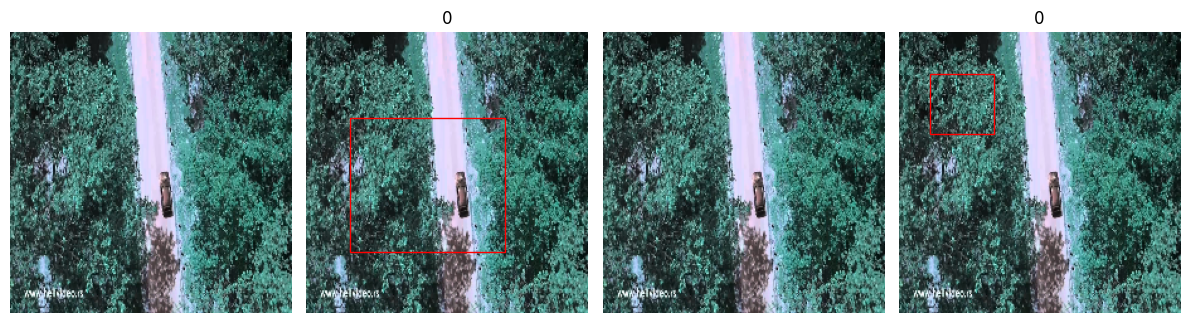

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
0.24544119834899902  seconds to predict bounding boxes.


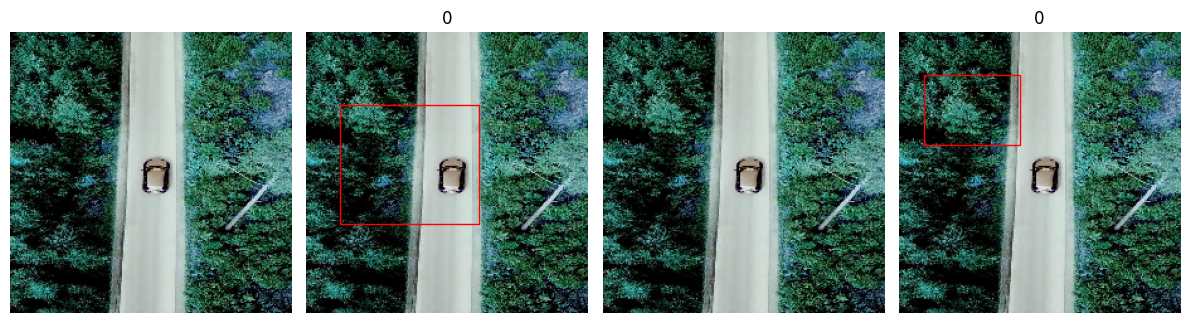

In [68]:
# Loop through the image filenames and process each image
for index in range(len(X_above)):
    start = time.time()
    image = np.expand_dims(X_above[index], axis=0)
    preds1 = mod_seq_bgr.predict(image)
    preds2 = mod_vgg_bgr.predict(image)
    print(time.time() - start, " seconds to predict bounding boxes.")
    x1, y1, x2, y2 = preds1.astype('int')[0]
    x3, y3, x4, y4 = preds2.astype('int')[0]
    display_images(X_above[index], x1, y1, x2, y2, 0, X_above[index], x3, y3, x4, y4, 0)
    